In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
from astropy import cosmology
from astropy.io import fits
from astropy import table
import SAGA

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [5]:
saga = SAGA.QuickStart(local_dir='../local_data/')
#'/path/to/saga/dropbox/folder', '/path/to/saga/local/folder')

SAGA `shared_dir` set to /Users/kadofong/work/surveys/saga/notebooks
SAGA `local_dir`  set to ../local_data/


In [6]:
saga.database["combined_base"].remote.path = "https://drive.google.com/uc?export=download&id=1WnGUfDCZwXEUsy4zgGFR1ez3ZE5DFtsB&confirm=t&uuid=d0f82ed0-6db5-4ca0-bb8f-6c54d44a17db"

In [7]:
saga.database["combined_base"].download(overwrite=False)

In [8]:
base = saga.object_catalog.load_combined_base_catalog()
base = saga.host_catalog.construct_host_query("paper3").filter(base)

In [223]:
from SAGA import utils
from SAGA.objects import cuts

cleaner = (base['REMOVE']==0)&base['is_galaxy']&(base['ZQUALITY']>=3)
clean = base[cleaner]

clean['selection'] = 0
utils.fill_values_by_query(clean, cuts.paper1_targeting_cut|cuts.main_targeting_cuts, {'selection':4})
saga_relaxed = clean[clean['selection']==4].to_pandas ().set_index('OBJID')
saga_relaxed['cm_mass'] = colormass_masses ( saga_relaxed['SPEC_Z'], saga_relaxed['gr'], saga_relaxed['Mr'] )

In [250]:
clean = base[(base['REMOVE']==0)&base['is_galaxy']].to_pandas ().set_index('OBJID')
clean = clean.loc[clean['ZQUALITY']>=3]
clean = clean.loc[clean['gr_err'] < 1.] # \\ have all colors measured 

In [251]:
from SAGA import targets

In [252]:
#out = targets.assign_targeting_score.assign_targeting_score_v3 ( base, ignore_specs=True)

In [253]:
# \\ only SAGA spec
telescopes = ['MMT','AAT']
lowz = clean.loc[np.in1d(clean['TELNAME'], telescopes)]
lowz = lowz.query('SPEC_Z<=0.2')

In [254]:
gama = fits.getdata('../../gama/local_data/StellarMassesLambdarv24.fits',1)
gama = table.Table(gama).to_pandas ()
gama = gama.set_index('CATAID')

gama_sersic = fits.getdata('../../gama/local_data/SersicCatSDSSv09.fits',1)
gama_sersic = table.Table(gama_sersic).to_pandas ()
gama_sersic = gama_sersic.set_index('CATAID')

gama_lambdar = table.Table(fits.getdata('../../gama/local_data/LambdarCatv01.fits',1)).to_pandas().set_index('CATAID')
gama_lambdar = gama_lambdar.reindex(gama.index)

In [257]:
gama['gminusr'] = -2.5*np.log10(gama_lambdar['g_flux']/gama_lambdar['r_flux'])
for band in 'griz':
    gama[band] = -2.5*np.log10(gama_lambdar[f'{band}_flux']) + 8.9
    gama[f'u_{band}'] = 2.5/(gama_lambdar[f'{band}_flux']*np.log(10.))*gama_lambdar[f'{band}_fluxerr']
gama['GALSB_r'] = gama['r'] + 2.5*np.log10(2.*np.pi*gama_sersic['GALRE_r']**2)    
#gama['r'] = gama_sersic['r']
gama = gama.loc[(gama['gminusr']>-2)&(gama['gminusr']<3.)].copy()
gama = gama.query('(Z<0.2)&(Z>0.005)')

/opt/miniconda3/envs/cenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/cenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [259]:
g_matrix = [[0., 0., 0., 0.],
                [-0.900332, 3.97338, 0.774394, -1.09389],
                [3.65877, -8.04213, 11.0321, 0.781176],
                [-16.7457, -31.1241, -17.5553, 0],
                [87.3565, 71.5801, 0., 0.],
                [-123.671, 0, 0, 0]]
g_matrix = np.asarray(g_matrix)

r_matrix = [[0.,0.,0.,0.],
            [-1.61294, 3.81378, -3.56114, 2.47133],
            [9.13285, 9.85141, -5.1432, -7.02213],
            [-81.8341, -30.3631, 38.5052, 0.0],
            [250.732, -25.0159, 0.0, 0.0],
            [-215.377, 0.0, 0.0, 0.0]]
r_matrix = np.asarray(r_matrix)
            
kcorr_d = {'g':g_matrix,'r':r_matrix}
logml = lambda gr: 1.65*gr - 0.66

def kcorrect ( z, gr, bandpass ):
    if isinstance(z, float):
        kcorr_est = 0.
    else:
        kcorr_est = np.zeros(z.shape)
    for x_idx in range(5):
        for y_idx in range(4):
            coeff = kcorr_d[bandpass][x_idx, y_idx]
            term = coeff * z**x_idx * gr**y_idx
            kcorr_est += term
    return kcorr_est

def colormass_masses ( z, obsgr, Mr, zp_g = 5.11 ):
    kcorr_g = kcorrect ( z, obsgr, 'g' )
    kcorr_r = kcorrect ( z, obsgr, 'r' )
    gr_restframe = obsgr + kcorr_g - + kcorr_r
    M_g = Mr + gr_restframe
    
    loglum_g = (M_g-zp_g)/-2.5
    logsmass = logml(gr_restframe) + loglum_g    
    return logsmass

In [260]:
lowz['cm_mass'] = colormass_masses ( lowz['SPEC_Z'], lowz['gr'], lowz['Mr'] )
gama['Mr'] = gama['r'] - cosmo.distmod(gama['Z'].values).value 
gama['Mr'] -= kcorrect ( gama['Z'], gama['gminusr'], 'r')
gama['cm_mass'] = colormass_masses ( gama['Z'], gama['gminusr'], gama['Mr'] )

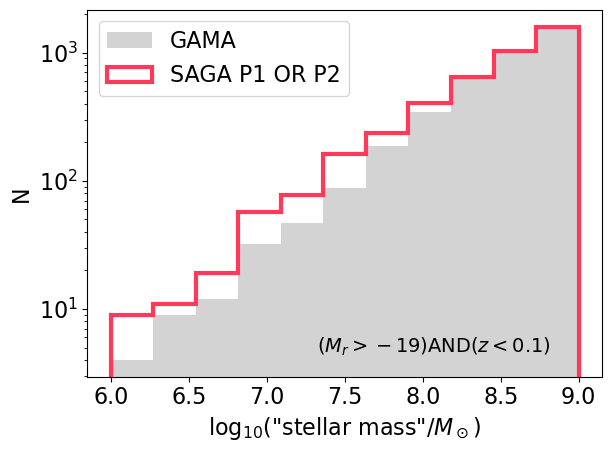

In [261]:
mbins = np.linspace(6.,9.,12)
cc="#ff395a"
ax = plt.subplot(111)
plt.hist(gama.query('(absmag_r>-19.)&(Z<0.1)&(cm_mass<9.)')['cm_mass'], bins=mbins, label='GAMA', color='lightgrey')
plt.hist(saga_relaxed.query('(Mr>-19.)&(SPEC_Z<0.1)&(cm_mass<9.)')['cm_mass'], bins=mbins, histtype='step', lw=3, label='SAGA P1 OR P2', color=cc)
plt.yscale('log')
plt.xlabel(r'log$_{10}$("stellar mass"$/M_\odot$)')
plt.ylabel(r'N')
plt.legend ()
plt.text (0.9, 0.05, r'$(M_r>-19){\rm AND}(z<0.1)$', ha='right', va='bottom', transform=ax.transAxes, size=14)
plt.tight_layout()
plt.savefig('../figures/GAMA_SAGA_masscomparison.png')

In [262]:
gama_rlim = 19.8
saga_rlim = 20.75
saga_grlim = lambda r: 0.9 - 0.06*(r-14.) # must be bluer than <
saga_sblim = lambda r: 18.5 + 0.7*(r-14.) # must be fainter than >

In [263]:
c_gama_sl = gama['gminusr'] <= saga_grlim(gama['r'])
c_gama_sl &= gama['GALSB_r'] >= saga_sblim(gama['r'])
#c_gama_sl &= gama['r'] <= gama_rlim # apply GAMA's own maglim
gama_sl = gama.loc[c_gama_sl].copy()

In [264]:
c_saga_gl = lowz['r_mag'] <= gama_rlim
c_saga_gl &= lowz['gr'] <= saga_grlim(lowz['r_mag']) # apply SAGA's own colorcut
c_saga_gl &= lowz['sb_r'] >= saga_sblim(lowz['r_mag']) # apply SAGA's own SB cut
saga_gl = lowz.loc[c_saga_gl].copy()

In [265]:
gama_dwarfs = gama.query('cm_mass<9.')
saga_dwarfs = lowz.query('cm_mass<9.')

In [288]:
lb

10.0

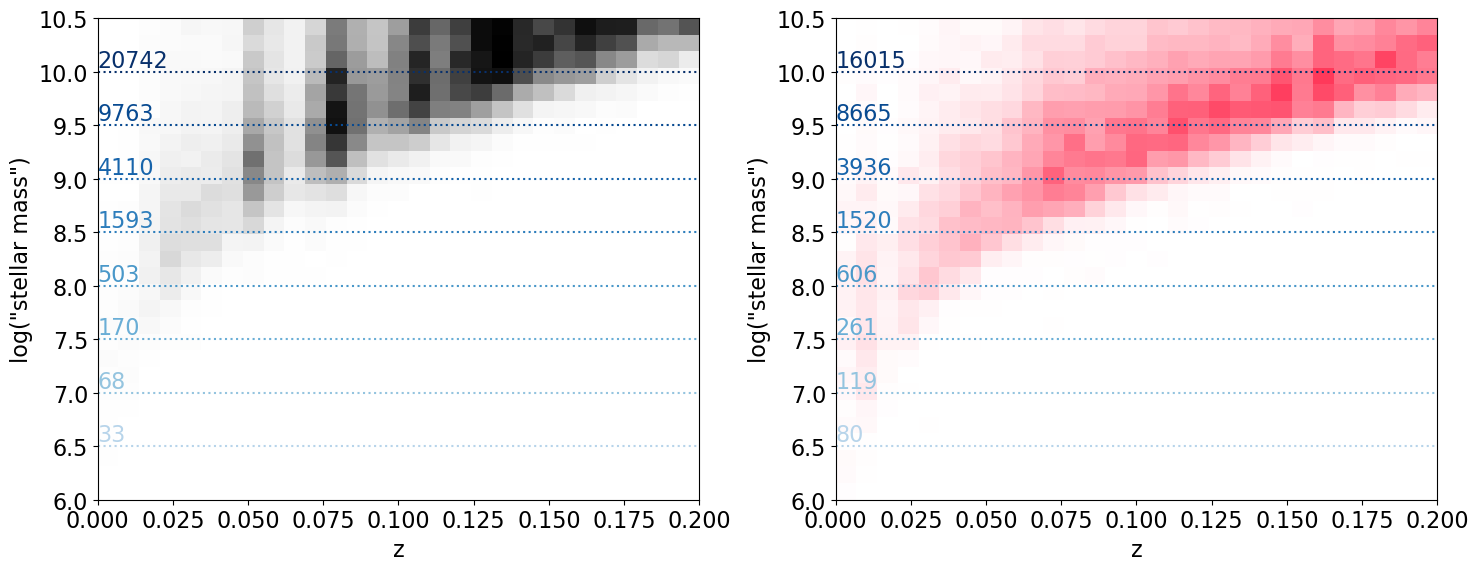

In [295]:
from matplotlib import colors

fig, axarr = plt.subplots(1,2,figsize=(15,6))
cmap = colors.LinearSegmentedColormap.from_list('',['w',cc],256)
bins_l = [np.linspace(0.,0.2,30), np.linspace(6.,10.5,30)]
_=axarr[0].hist2d ( gama['Z'], gama['cm_mass'], bins=bins_l, cmap='Greys' )
_=axarr[1].hist2d ( lowz['SPEC_Z'], lowz['cm_mass'], bins=bins_l, cmap=cmap)
for lb in np.arange(6.5,10.5,.5):
    ngama = gama.query(f'cm_mass<{lb}').shape[0]
    nsaga = lowz.query(f'cm_mass<{lb}').shape[0]
    for txtindex, txt in enumerate([ngama,nsaga]):
        axarr[txtindex].text ( 0., lb, txt, ha='left',va='bottom', 
                              color=plt.cm.Blues((lb-5.)/(10.-5.)))
for ax in axarr:
    ax.set_xlabel('z')
    ax.set_ylabel ('log("stellar mass")')
    for lb in np.arange(6.5,10.5,.5):
        ax.axhline(lb,color=plt.cm.Blues((lb-5.)/(10.-5.)) ,ls=':')
plt.tight_layout ()
plt.savefig("../figures/blandcomparison.png")

# Cut comparison

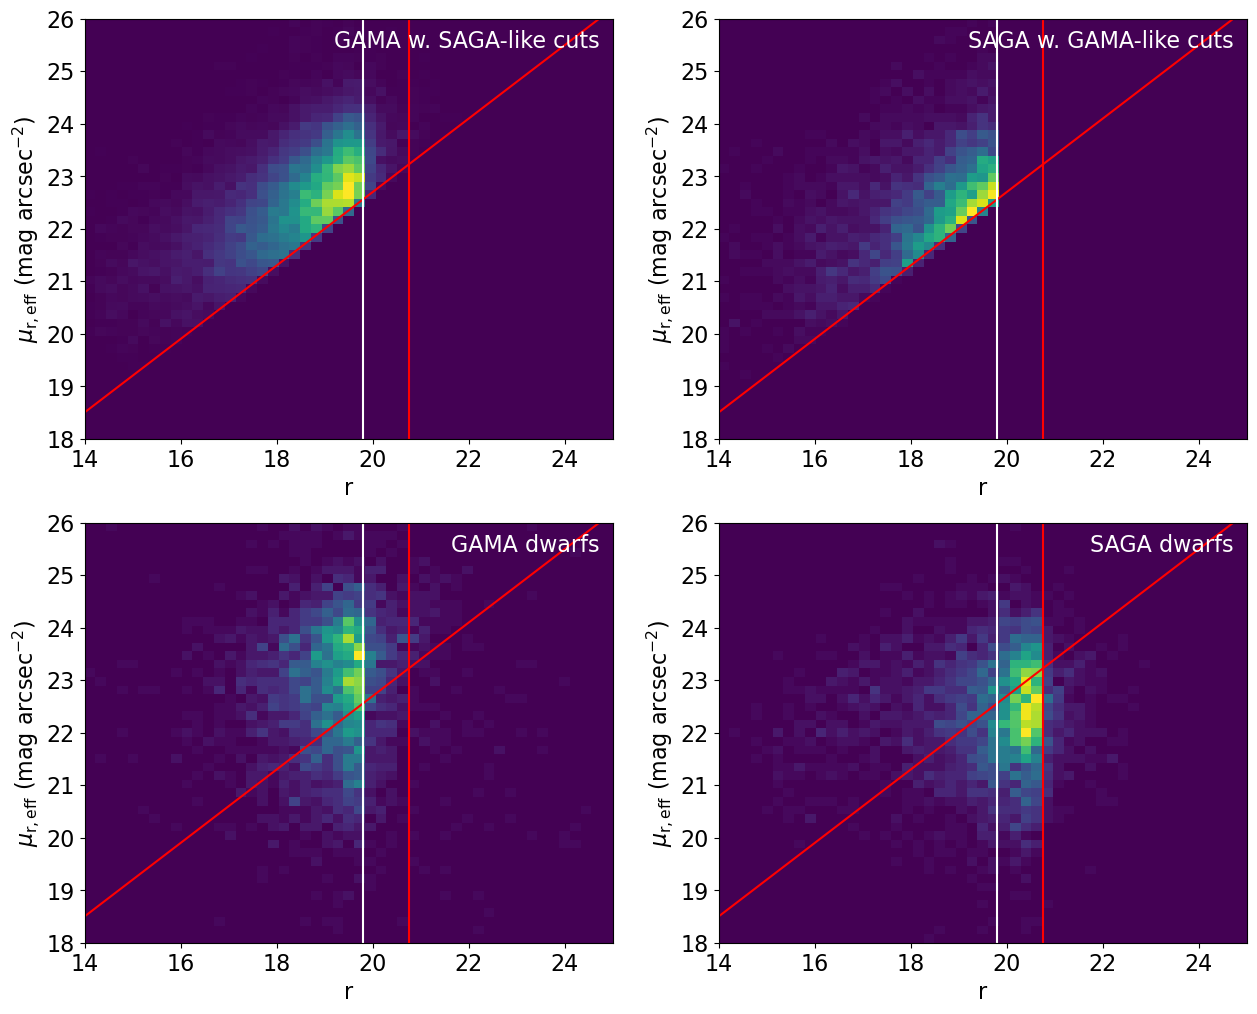

In [191]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(14.,25.,50), np.linspace(18.,26.,50)]
axarr[0,0].hist2d ( gama_sl['r'], gama_sl['GALSB_r'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['r_mag'], saga_gl['sb_r'], bins=bins_l)
axarr[1,0].hist2d ( gama_dwarfs['r'], gama_dwarfs['GALSB_r'], bins=bins_l)
axarr[1,1].hist2d ( saga_dwarfs['r_mag'], saga_dwarfs['sb_r'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA dwarfs','SAGA dwarfs']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_sblim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axvline(saga_rlim, color='r')
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\mu_{\rm r,eff}$ (mag arcsec$^{-2}$)')

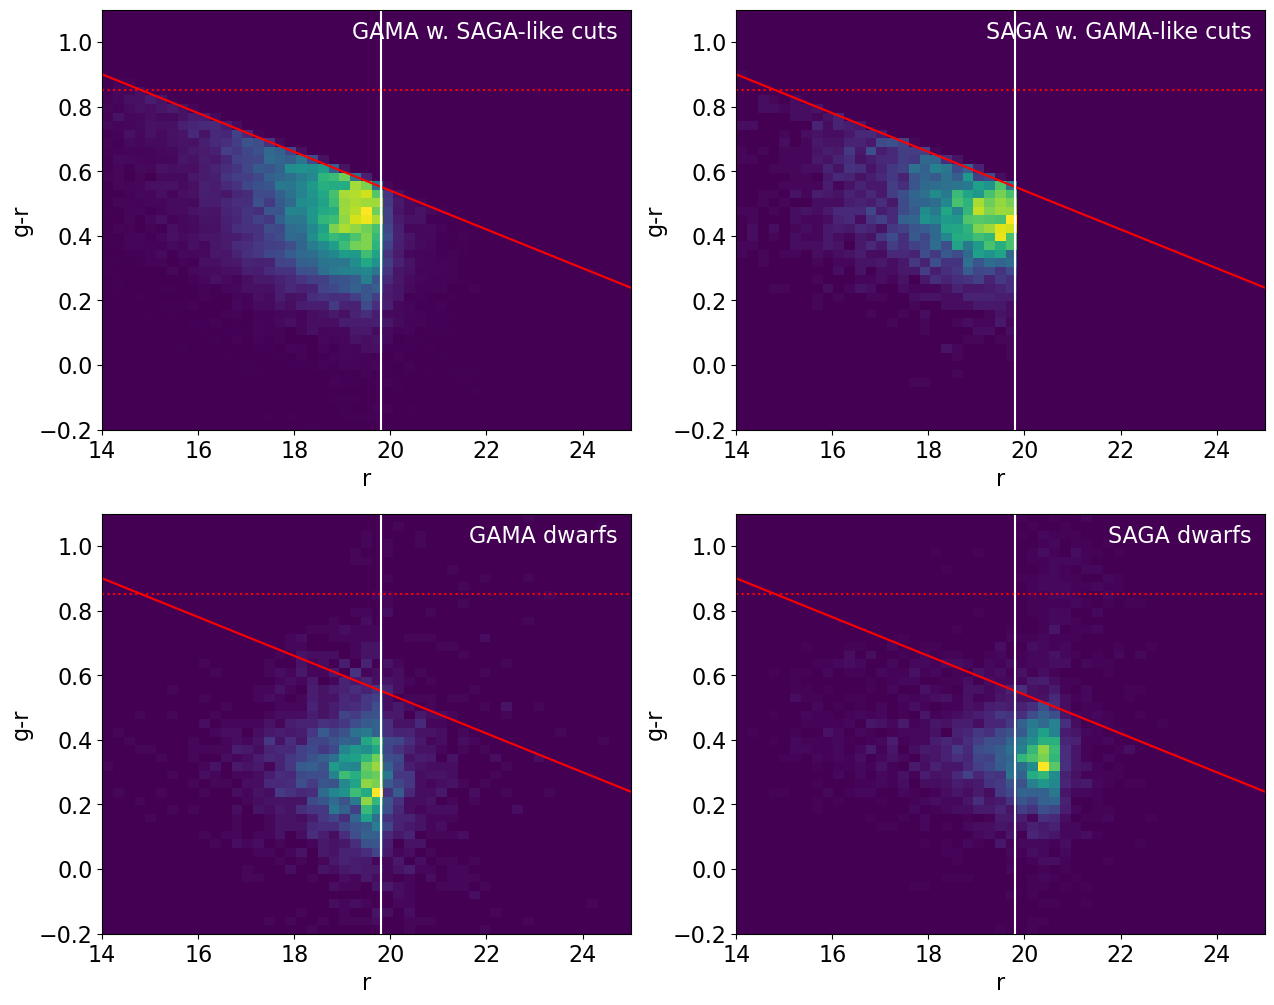

In [192]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(14.,25.,50), np.linspace(-0.2,1.1,50)]
axarr[0,0].hist2d ( gama_sl['r'], gama_sl['gminusr'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['r_mag'], saga_gl['gr'], bins=bins_l)
axarr[1,0].hist2d ( gama_dwarfs['r'], gama_dwarfs['gminusr'], bins=bins_l)
axarr[1,1].hist2d ( saga_dwarfs['r_mag'], saga_dwarfs['gr'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA dwarfs','SAGA dwarfs']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axhline(0.85, color='r', ls=':')
    ax.set_xlabel('r')
    ax.set_ylabel('g-r')

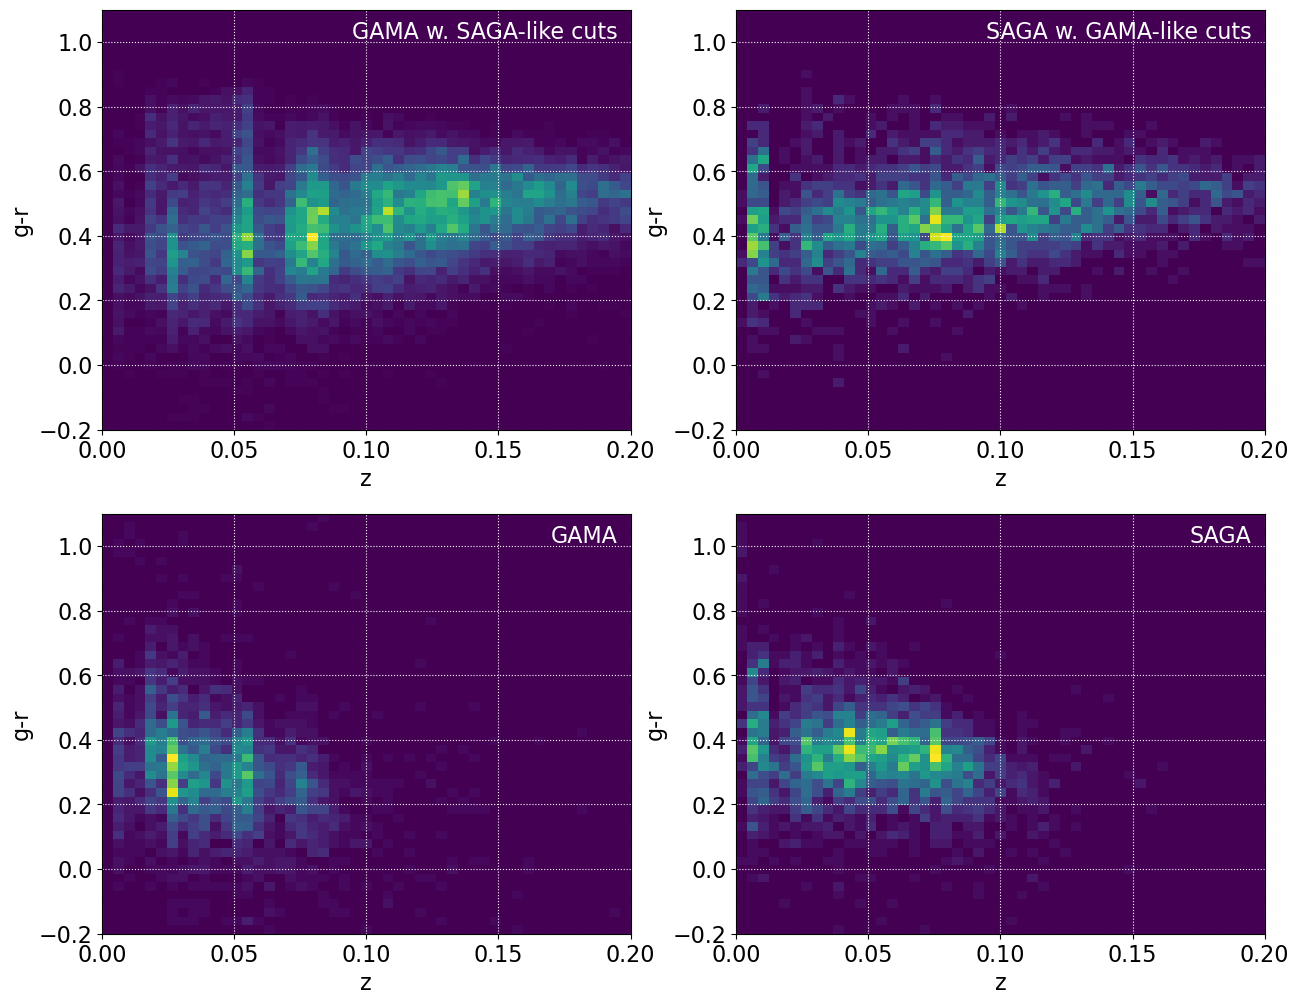

In [193]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(0., 0.2,50), np.linspace(-0.2,1.1,50)]
axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['gminusr'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['gr'], bins=bins_l)
axarr[1,0].hist2d ( gama_dwarfs['Z'], gama_dwarfs['gminusr'], bins=bins_l)
axarr[1,1].hist2d ( saga_dwarfs['SPEC_Z'], saga_dwarfs['gr'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel('g-r')
    ax.grid(color='w',ls=':')

In [194]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])

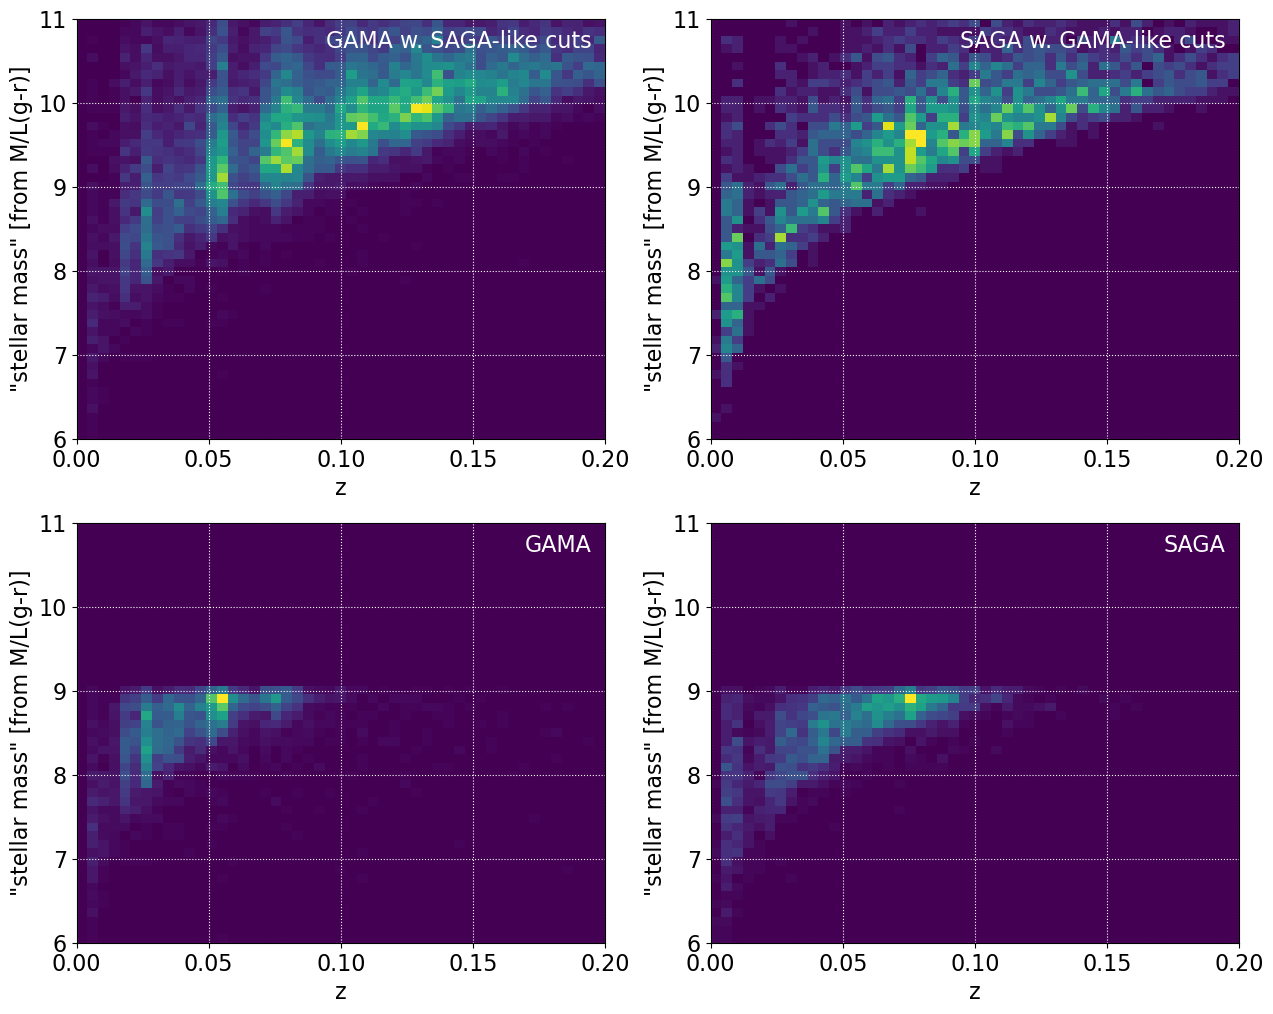

In [195]:
fig, axarr = plt.subplots(2,2,figsize=(15,6*2))
bins_l = [np.linspace(0., 0.2,50), np.linspace(6.,11.,50)]
out = axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['cm_mass'], bins=bins_l)
axarr[1,0].hist2d( gama_dwarfs['Z'], gama_dwarfs['cm_mass'], bins=bins_l )
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['cm_mass'], bins=bins_l)
axarr[1,1].hist2d( saga_dwarfs['SPEC_Z'], saga_dwarfs['cm_mass'], bins=bins_l )
#axarr[1].contour (  midpts(out[1]), midpts(out[2]), out[0].T, colors='r')

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    #ax.axvline(gama_rlim, color='w')
    ax.set_xlabel('z')
    ax.set_ylabel('"stellar mass" [from M/L(g-r)]')
    ax.grid(color='w',ls=':')

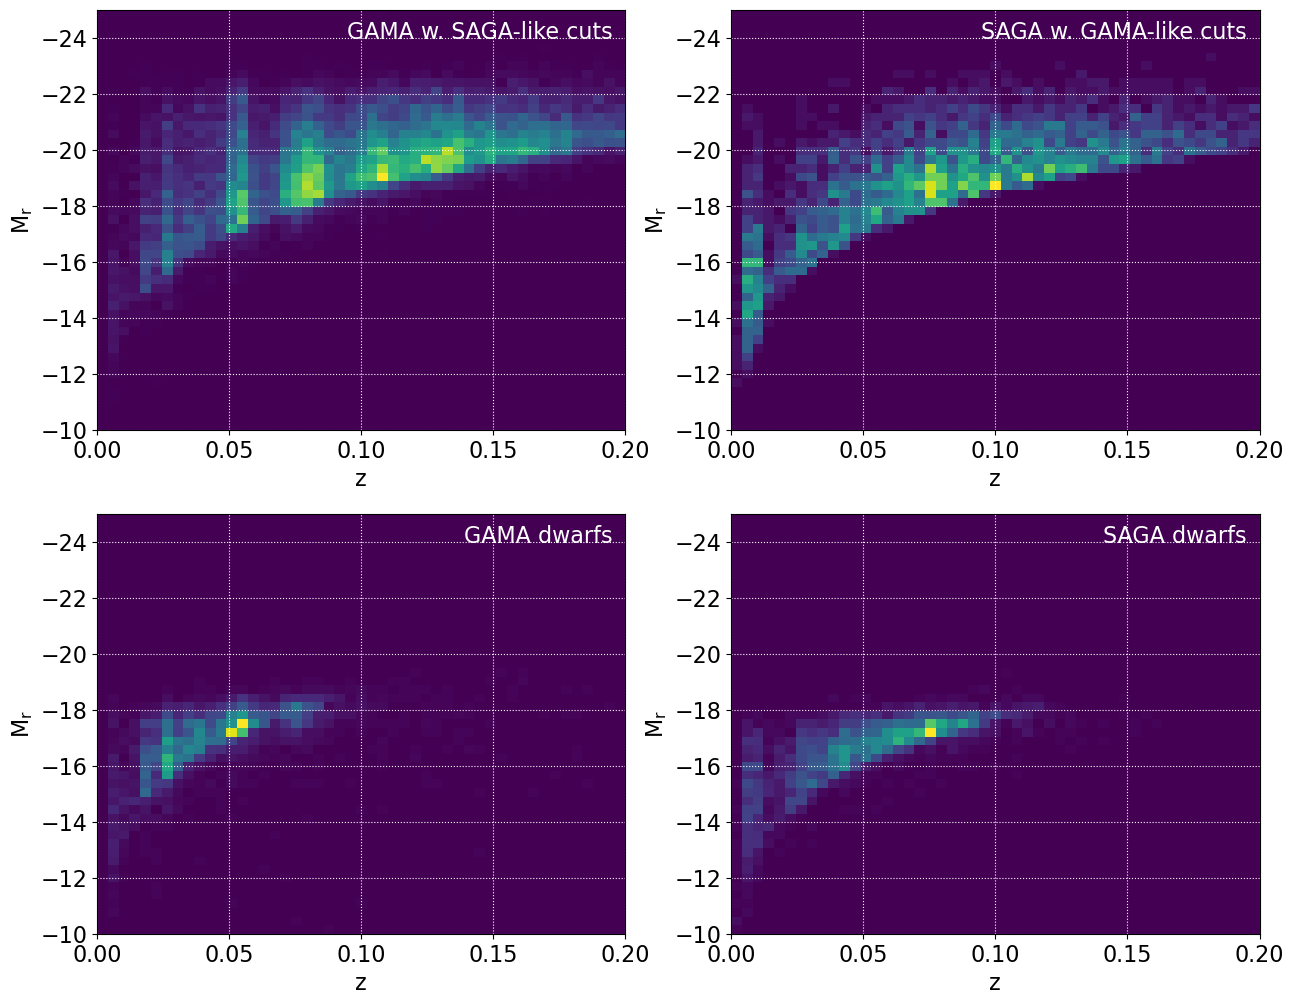

In [196]:
fig, axarr = plt.subplots(2,2,figsize=(15,6*2))
bins_l = [np.linspace(0., 0.2,50), np.linspace(-25,-10,50)]

out = axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['absmag_r'], bins=bins_l)
axarr[1,0].hist2d( gama_dwarfs['Z'], gama_dwarfs['absmag_r'], bins=bins_l )
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['Mr'], bins=bins_l)
axarr[1,1].hist2d( saga_dwarfs['SPEC_Z'], saga_dwarfs['Mr'], bins=bins_l )


text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA dwarfs','SAGA dwarfs']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])

# Stats on SAGA primary targeting region

In [197]:
c_saga_pt = lowz['gr'] <= saga_grlim(lowz['r_mag']) # apply SAGA's own colorcut
c_saga_pt &= lowz['sb_r'] >= saga_sblim(lowz['r_mag'])
saga_pt = lowz.loc[c_saga_pt].copy() # SAGA primary
saga_out = lowz.loc[~c_saga_pt].copy() # SAGA exploration
saga_out = saga_out.loc[saga_out['r_mag'] <= saga_rlim]

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/3721949583.py:11: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])


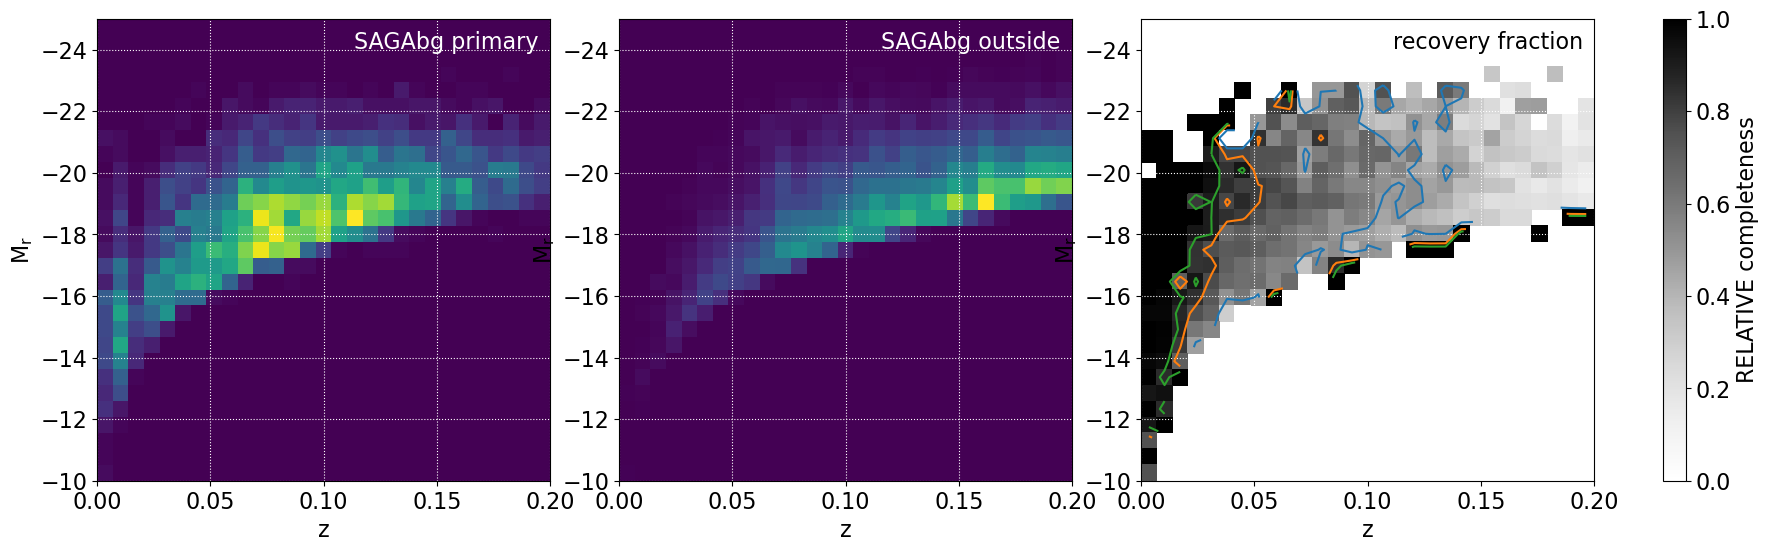

In [198]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( saga_pt['SPEC_Z'], saga_pt['Mr'], bins=bins_l)
outhist = axarr[1].hist2d ( saga_out['SPEC_Z'], saga_out['Mr'], bins=bins_l)

resource_factor = outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_pt.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg primary', 'SAGAbg outside', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/2764789891.py:11: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])


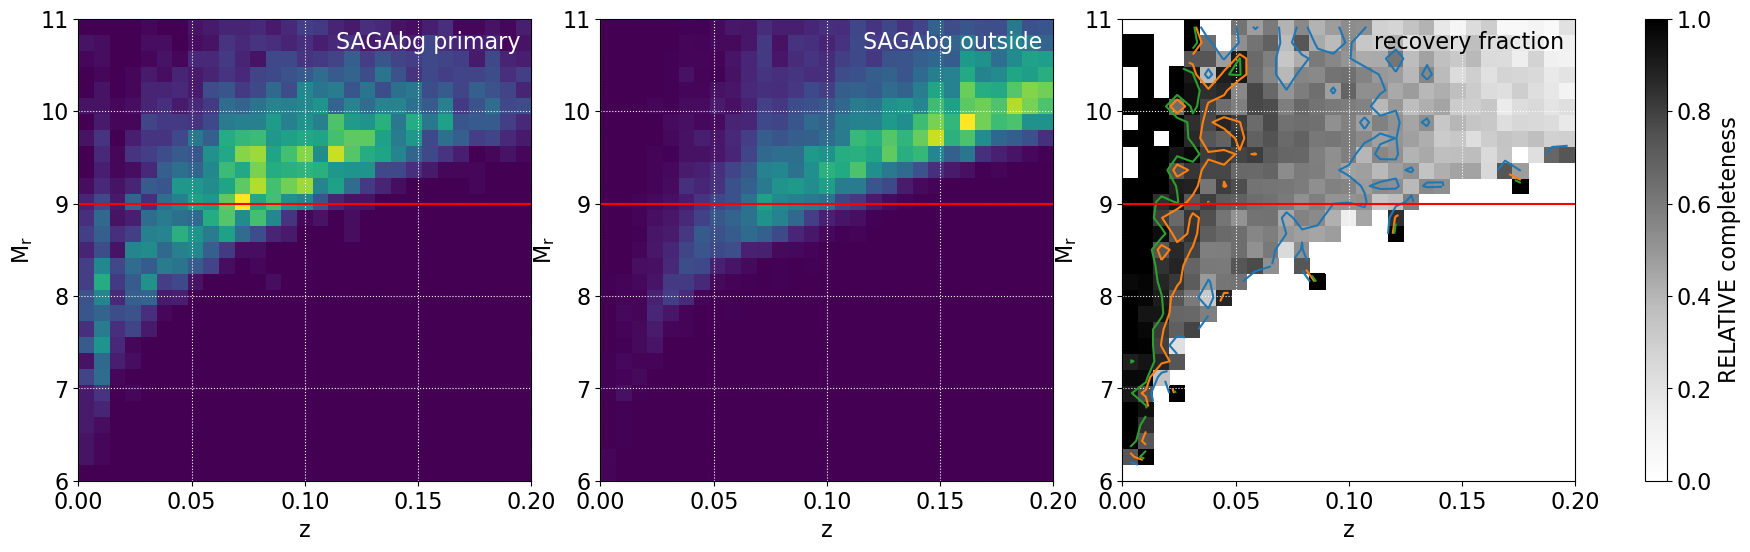

In [58]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(6.,11.,nbins)]

inhist = axarr[0].hist2d ( saga_pt['SPEC_Z'], saga_pt['cm_mass'], bins=bins_l)
outhist = axarr[1].hist2d ( saga_out['SPEC_Z'], saga_out['cm_mass'], bins=bins_l)

resource_factor = outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_pt.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg primary', 'SAGAbg outside', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.axhline(9.,color='r')

# Some stats noodling

In [91]:
# how probable is it to draw a negative number if 
# samples are unbalanced
Ux = np.random.uniform(0.,10.,100000)
ax = np.random.normal(5.,1.,1000)

In [116]:
pinside = lambda x,m=5.,s=1.: (2.*np.pi*s**2)**(-0.5) * np.exp(-(x-m)**2/(2.*s**2))
puniform = lambda x, xmin=0., xmax=10.: np.ones_like(x) / (xmax-xmin)

In [93]:
bins = np.arange(0.,10.,.25)

In [94]:
counts_ax = np.zeros_like(bins)
assns_ax, _counts_ax = np.unique(np.digitize(ax, bins), return_counts=True)
counts_ax[assns_ax] = _counts_ax
assns_ux, counts_ux = np.unique(np.digitize(Ux, bins), return_counts=True)

In [106]:
(Ux<5.).sum()

49787

In [109]:
.5*ax.size / (.5 * Ux.size) * Ux.size/ax.size

1.0

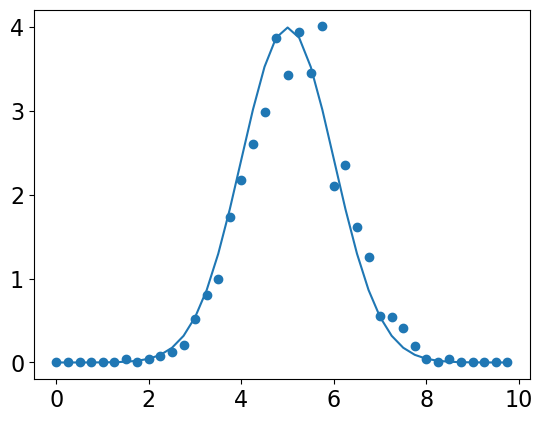

In [120]:
plt.plot(bins, pinside(bins)/puniform(bins))
#plt.plot(bins, puniform(bins))
plt.scatter(bins, counts_ax/counts_ux * Ux.size/ax.size)


In [144]:
#pinside = lambda x,m=5.,s=1.: (2.*np.pi*s**2)**(-0.5) * np.exp(-(x-m)**2/(2.*s**2))
p1 = lambda x: pinside(x, 5.,1.)
p2 = lambda x: pinside(x, 6.,2.)
s1 = np.random.normal(5.,1.,10000)
s2 = np.random.normal(6.,2.,12000)
bins = np.arange(0.,15.,.25)
counts_s1 = np.zeros_like(bins)
assns_s1, _counts_s1 = np.unique(np.digitize(s1, bins), return_counts=True)
counts_s1[assns_s1] = _counts_s1

counts_s2 = np.zeros_like(bins)
assns_s2, _counts_s2 = np.unique(np.digitize(s2, bins), return_counts=True)
counts_s2[assns_s2] = _counts_s2

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_2013/2390003158.py:2: RuntimeWarning: invalid value encountered in divide
  plt.scatter(bins, counts_s1/counts_s2 * counts_s2.sum()/counts_s1.sum() )


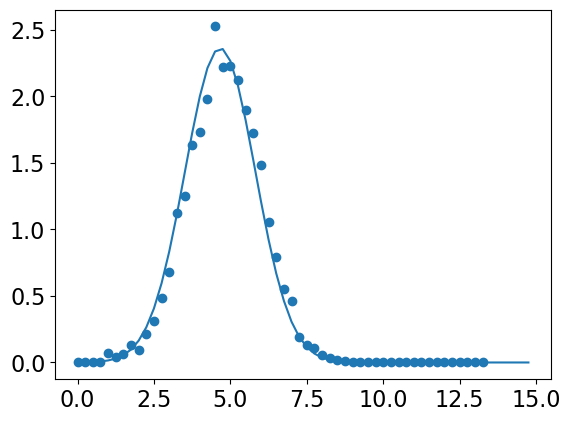

In [147]:
plt.plot(bins,p1(bins)/p2(bins))
plt.scatter(bins, counts_s1/counts_s2 * counts_s2.sum()/counts_s1.sum() )

# GAMA internal comparison

In [199]:
#c_gama_sl = gama['gminusr'] <= saga_grlim(gama['r'])
#c_gama_sl &= gama['GALSB_r'] >= saga_sblim(gama['r'])
#c_gama_sl &= gama['r'] <= gama_rlim # apply GAMA's own maglim
#gama_sl = gama.loc[c_gama_sl].copy() # GAMA, SAGA-like

In [200]:
#gama_out = gama.loc[gama['r']<=gama_rlim]
# lowz.loc[~c_saga_pt].copy()
gama_out = gama.loc[~c_gama_sl]
gama_out = gama_out.loc[gama_out['r']<=gama_rlim].copy()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/2809995650.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])


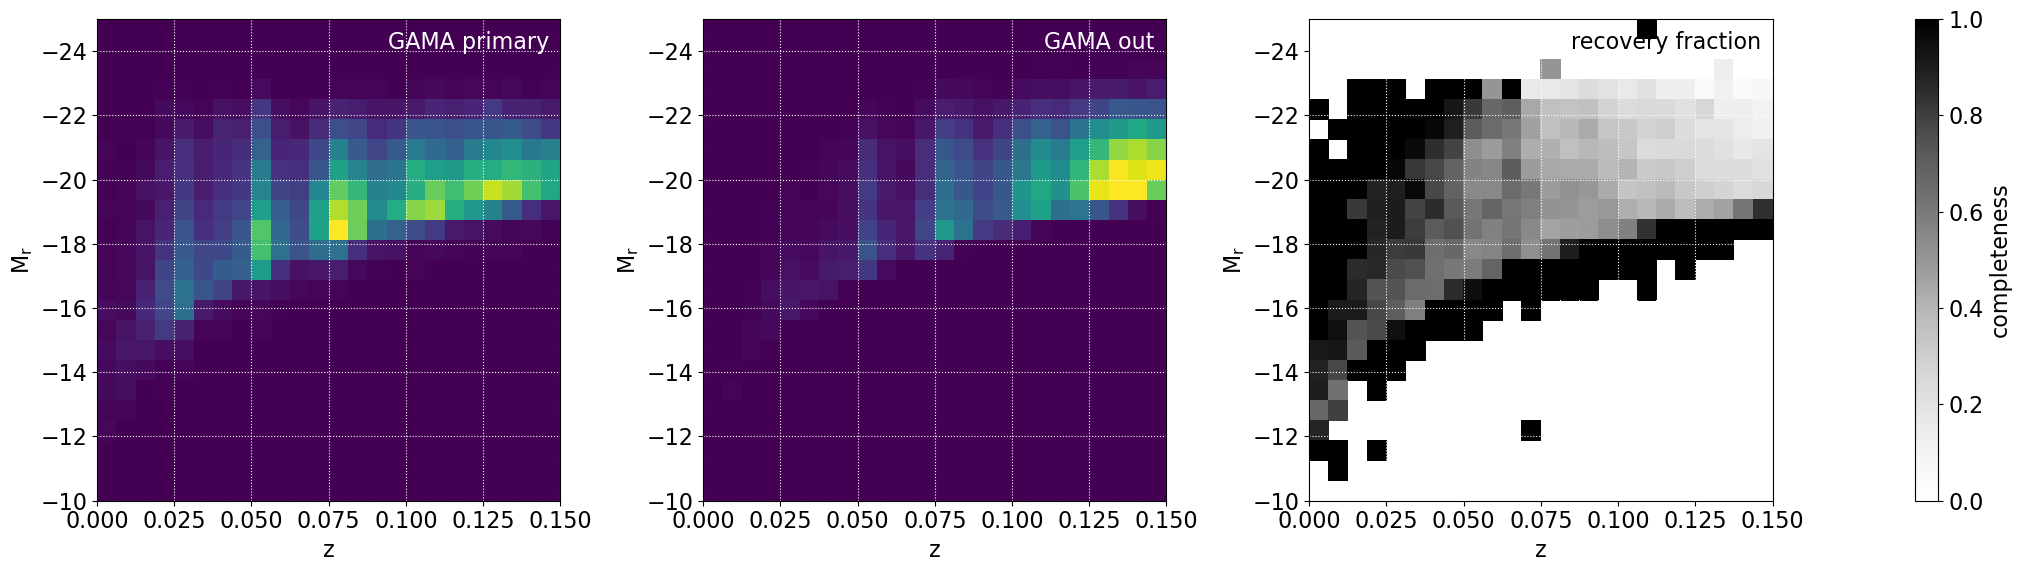

In [201]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 25
bins_l = [np.linspace(0., 0.15,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( gama_sl['Z'], gama_sl['absmag_r'], bins=bins_l)
outhist = axarr[1].hist2d ( gama_out['Z'], gama_out['absmag_r'], bins=bins_l)

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
#axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='completeness')

text = ['GAMA primary', 'GAMA out', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout ()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/4003301401.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])


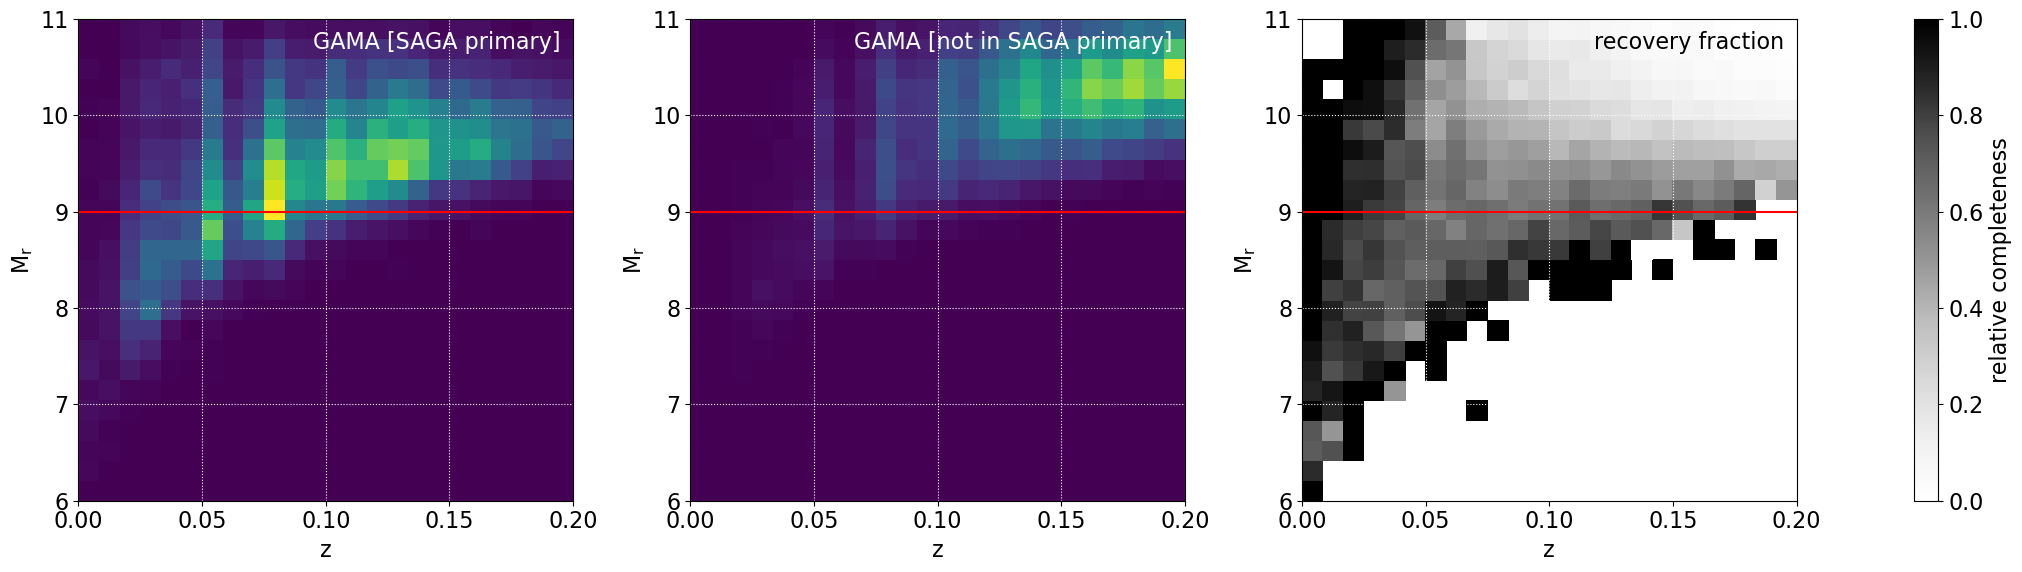

In [202]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 25
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(6.,11.,nbins)]

inhist = axarr[0].hist2d ( gama_sl['Z'], gama_sl['logmstar'], bins=bins_l)
outhist = axarr[1].hist2d ( gama_out['Z'], gama_out['logmstar'], bins=bins_l)

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
#axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='relative completeness')

text = ['GAMA [SAGA primary]', 'GAMA [not in SAGA primary]', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.axhline(9.,color='r')
    
plt.tight_layout ()

## now check P1 cuts

In [206]:
gr_cut = gama['g']-gama['r'] + 2.*(gama['u_g']**2+gama['u_r']**2)**.5 < 0.85
ri_cut = gama['r']-gama['i'] + 2.*(gama['u_r']**2+gama['u_i']**2)**.5 < 0.55
rz_cut = gama['r']-gama['z'] + 2.*(gama['u_r']**2+gama['u_z']**2)**.5 < 1.

sb_cut = gama['GALSB_r'] -0.6*(gama['r']-14.) > 18.55
gr2_cut = gama['g']-gama['r'] + 0.06*(gama['r']-14.) < 0.9

paperonecut = gr_cut&ri_cut&rz_cut
papertwocut = sb_cut&gr2_cut
gama_paperone = gama.loc[paperonecut|papertwocut]
gama_notinpaperone = gama.loc[(~paperonecut&~papertwocut)]

gama_papertwo = gama.loc[papertwocut]
gama_notinpapertwo = gama.loc[~papertwocut]

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/3962387068.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/3962387068.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  v_frac = ((inhist[0]+outhist[0])**-1 + inhist[0]/(inhist[0]+outhist[0])**2)**2 * inhist[0] + (inhist[0]/(inhist[0]+outhist[0])**2)**2*outhist[0]
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/3962387068.py:10: RuntimeWarning: invalid value encountered in divide
  v_frac = ((inhist[0]+outhist[0])**-1 + inhist[0]/(inhist[0]+outhist[0])**2)**2 * inhist[0] + (inhist[0]/(inhist[0]+outhist[0])**2)**2*outhist[0]
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/3962387068.py:12: RuntimeWarning: invalid value encountered in divide
  is_too_uncertain = ((u_frac*3.) > (inhist[0]/(inhist[0]+outhist[0]))).T*1.


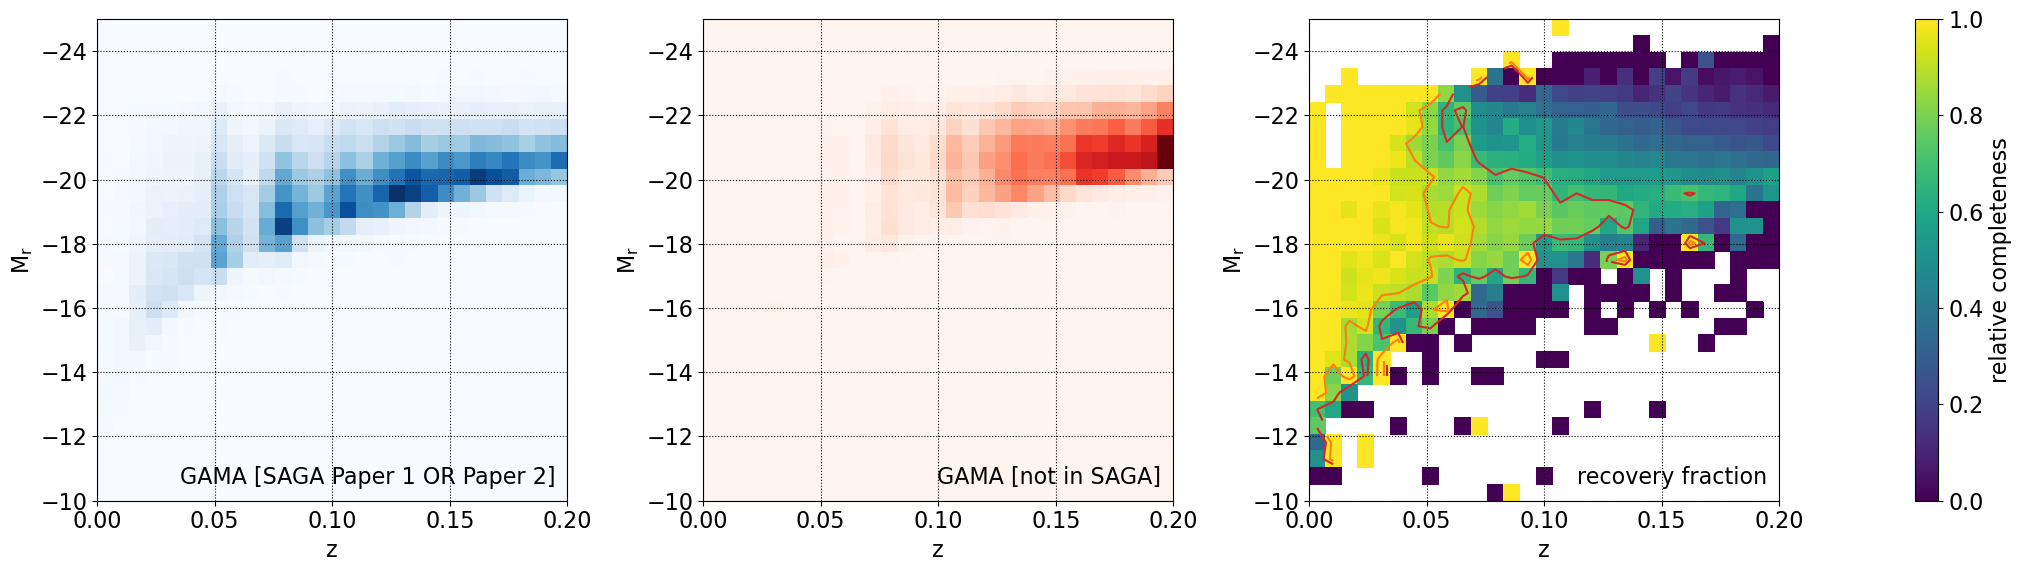

In [210]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins),np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( gama_paperone['Z'], gama_paperone['absmag_r'], bins=bins_l, cmap='Blues')
outhist = axarr[1].hist2d ( gama_notinpaperone['Z'], gama_notinpaperone['absmag_r'], bins=bins_l, cmap='Reds')

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
v_frac = ((inhist[0]+outhist[0])**-1 + inhist[0]/(inhist[0]+outhist[0])**2)**2 * inhist[0] + (inhist[0]/(inhist[0]+outhist[0])**2)**2*outhist[0]
u_frac = np.sqrt(v_frac)
is_too_uncertain = ((u_frac*3.) > (inhist[0]/(inhist[0]+outhist[0]))).T*1.

im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='viridis' )
#for ax in axarr:
#    ax.pcolor ( midpts(inhist[1]), midpts(inhist[2]), np.log10(is_too_uncertain), cmap='rainbow', shading='auto', alpha=0.1)
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['tab:red','tab:orange'], levels=[.7, .9])
plt.colorbar(im, cax=axarr[-1], label='relative completeness')

text = ['GAMA [SAGA Paper 1 OR Paper 2]', 'GAMA [not in SAGA]', 'recovery fraction']
cc_l = ['k','k','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.025, text[idx], ha='right', va='bottom', color=cc_l[idx], transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='k',ls=':')
    #ax.axhline(9.,color='r')
    ax.set_ylim(ax.get_ylim()[::-1])
    
plt.tight_layout ()
plt.savefig('../figures/GAMA_wSAGAselection.png')

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/2071979671.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/2071979671.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  v_frac = ((inhist[0]+outhist[0])**-1 + inhist[0]/(inhist[0]+outhist[0])**2)**2 * inhist[0] + (inhist[0]/(inhist[0]+outhist[0])**2)**2*outhist[0]
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/2071979671.py:10: RuntimeWarning: invalid value encountered in divide
  v_frac = ((inhist[0]+outhist[0])**-1 + inhist[0]/(inhist[0]+outhist[0])**2)**2 * inhist[0] + (inhist[0]/(inhist[0]+outhist[0])**2)**2*outhist[0]
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/2071979671.py:12: RuntimeWarning: invalid value encountered in divide
  is_too_uncertain = ((u_frac*3.) > (inhist[0]/(inhist[0]+outhist[0]))).T*1.


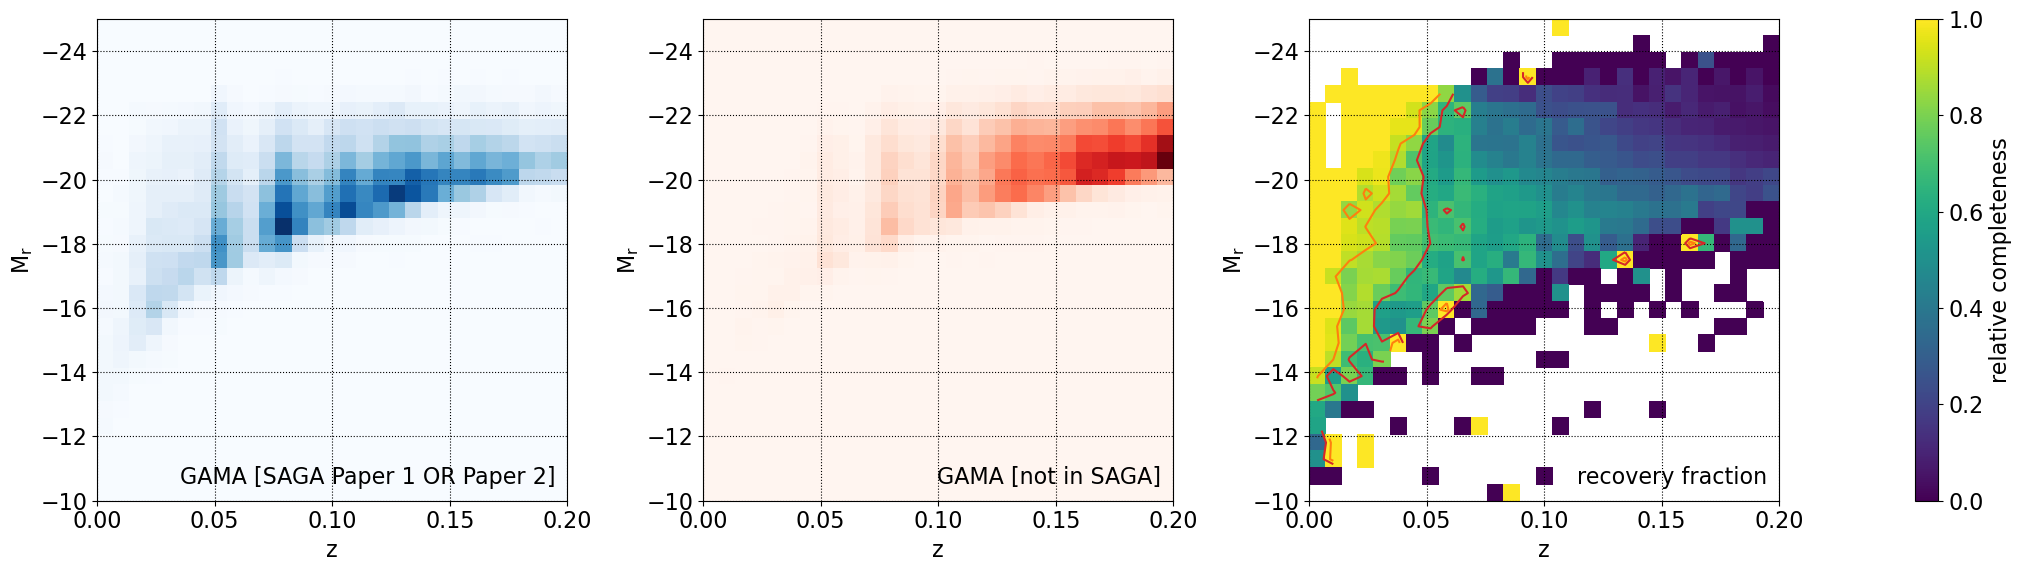

In [211]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins),np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( gama_papertwo['Z'], gama_papertwo['absmag_r'], bins=bins_l, cmap='Blues')
outhist = axarr[1].hist2d ( gama_notinpapertwo['Z'], gama_notinpapertwo['absmag_r'], bins=bins_l, cmap='Reds')

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
v_frac = ((inhist[0]+outhist[0])**-1 + inhist[0]/(inhist[0]+outhist[0])**2)**2 * inhist[0] + (inhist[0]/(inhist[0]+outhist[0])**2)**2*outhist[0]
u_frac = np.sqrt(v_frac)
is_too_uncertain = ((u_frac*3.) > (inhist[0]/(inhist[0]+outhist[0]))).T*1.

im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='viridis' )
#for ax in axarr:
#    ax.pcolor ( midpts(inhist[1]), midpts(inhist[2]), np.log10(is_too_uncertain), cmap='rainbow', shading='auto', alpha=0.1)
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['tab:red','tab:orange'], levels=[.7, .9])
plt.colorbar(im, cax=axarr[-1], label='relative completeness')

text = ['GAMA [SAGA Paper 1 OR Paper 2]', 'GAMA [not in SAGA]', 'recovery fraction']
cc_l = ['k','k','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.025, text[idx], ha='right', va='bottom', color=cc_l[idx], transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='k',ls=':')
    #ax.axhline(9.,color='r')
    ax.set_ylim(ax.get_ylim()[::-1])
    
plt.tight_layout ()
plt.savefig('../figures/GAMA_wSAGAselection-P2only.png')

In [151]:
gama_notinpaperone

,Z,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,delmstar,...,u_g,r,u_r,i,u_i,z,u_z,GALMAG_r,Mr,cm_mass
CATAID,,,,,,,,,,,,,,,,,,,,,
6802,0.05054,219.291260,5.990392,89.032333,0.564426,331.245605,8.965768,0.160297,9.879246e+08,3.574624e+08,...,0.0078,18.735399,0.0069,18.425600,0.0087,18.151699,-9999.0000,18.735399,-18.030759,9.305350
6803,0.16029,666.596130,6.305548,82.656204,0.652153,655.426514,10.357787,0.114158,2.356067e+10,5.952041e+09,...,0.0385,19.289101,0.0131,18.786100,0.0150,18.609100,0.0186,19.289101,-20.356075,11.233638
6816,0.07641,326.926605,6.051092,38.754528,0.303014,5486.959961,9.144924,0.166635,1.499485e+09,5.668656e+08,...,0.0300,20.118099,0.0493,19.467300,0.1025,19.945101,0.0853,20.118099,-17.570076,8.928193
6836,0.19657,809.037354,6.344537,67.958122,0.585595,1047.098999,10.256751,0.109759,1.863459e+10,4.632078e+09,...,0.0401,19.831499,0.0279,19.232000,0.0326,18.738100,0.1576,19.831499,-20.318690,11.009177
6840,0.19309,795.491516,6.349478,90.418861,0.665450,426.876526,10.788243,0.115839,6.352942e+10,1.606187e+10,...,0.0504,18.336201,0.0241,17.825701,0.0284,17.403400,0.1230,18.336201,-21.810726,11.877564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4223336,0.19985,821.586182,6.363669,65.410637,0.557781,1908.439819,10.095284,0.132017,1.303487e+10,3.939611e+09,...,0.0327,19.968300,0.0194,19.507401,-9999.0000,19.167999,0.0421,19.968300,-20.245796,11.083218
4227686,0.16838,698.577515,6.311191,44.744671,0.452673,5515.168945,8.524396,0.140587,3.525083e+08,1.169137e+08,...,0.7240,21.140400,0.0975,21.335800,-9999.0000,-9999.000000,-9999.0000,21.140400,-18.484018,9.646402
4289420,0.01877,83.228096,5.994111,48.874416,0.109573,623.948303,8.387800,0.107534,2.512861e+08,5.660074e+07,...,-9999.0000,20.485300,-9999.0000,19.995899,0.0345,18.963400,1.0390,20.485300,-14.182433,9.078647


In [49]:
gama['in_saga'] = False
gama.loc[gama_sl.index,'in_saga']= True

In [50]:
import pandas as pd

In [51]:
zbins = np.linspace(0.,.2,20)
assns = np.digitize(gama['Z'], zbins)
completeness_df = pd.DataFrame()
completeness_df['zmed'] = np.NaN
completeness_df['grp'] = np.unique(assns)
for masslim in [9., 9.6]:
    ml = str(np.round(masslim,1))
    for name, grp in gama.groupby(assns):
        completeness_df.loc[name-1, 'zmed'] = zbins[name-1]
        is_dwarf = (grp['logmstar']<masslim)&(grp['logmstar']>6.)
        completeness_df.loc[name-1, f'dwarf_{ml}_completeness'] = grp.loc[is_dwarf, 'in_saga'].sum() / is_dwarf.sum()
        #completeness_df.loc[name-1, f'dwarf_{ml}_purity_gama'] = (grp.loc[grp.in_saga,'logmstar']<masslim).sum() / grp.in_saga.sum()


/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7677/1729258472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gama_dwarfs['sb_r'] = gama_dwarfs['GALSB_r']


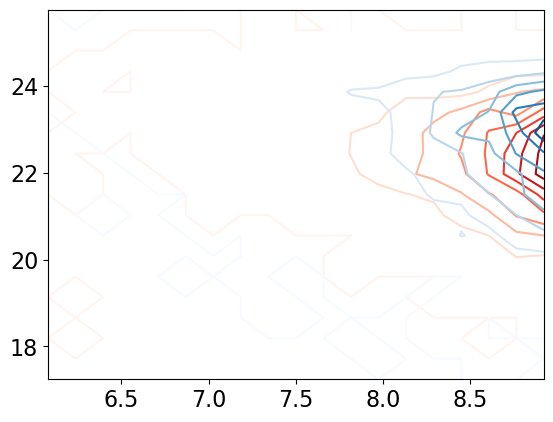

In [68]:
gama_dwarfs['sb_r'] = gama_dwarfs['GALSB_r']
bins_l = [np.linspace(6.,9.,20), np.linspace(17.,26.,20)]
cc_l = ['Reds','Blues']
for idx,dwarfs in enumerate([saga_dwarfs, gama_dwarfs]):
    out = np.histogram2d ( dwarfs['cm_mass'], dwarfs['sb_r'], bins=bins_l)
    plt.contour ( midpts(out[1]), midpts(out[2]),out[0].T, cmap=cc_l[idx]) 